## Q-Learning with Feed-forward Neural Networks

Reinforcement learning covers a broad range of problems where we would like to provide only a sparse feedback signal (in either spatial or temporal terms) and still have an agent learn to solve the problem of interest. Such problems are of the sort where manually labeling feedback (such as used for supervised learning) would be too cumbersome or time-consuming. Often, it is easy to describe situations which are "good" or "preferable" in some way rather than enumarating all of the steps needed to create such situations. We typically quantify these preferences in terms of a *scalar reward* which describes the level of "goodness" (positive) or "badness" (negative) with zero being an essentially neutral condition.

For this example, we will utilize a feed-forward network to learn the so-called *Q-function* for a reinforcement learning agent which learns to solve a simple task while being provided a relatively simple, well-defined reward profile. The *Q-function* is an estimate of the *learned* value of state-action pairs, which can be leveraged for proper action selection and maximization of the *sum of discounted future rewards* that the agent receives. While the Q-function is often represented by an array which enumerates all possible state-action pairs and encodes the so-called Q-values for all such pairs, it is far more preferable to utilize a neural network for storing these values (learning the Q-function).

## The Cart-Pole Problem

We will be solving the classic cart-pole problem borrowed from the OpenAI Gym framework. OpenAI Gym is a good resource for learning how to program reinforcement learning agents since the gym provides a set of problem environments with a consistent, common interface. This allows us to focus on the development of the agent instead of the development of the environment. Nevertheless, some familiarity with the environment will be needed to start building the agent. One other interesting property of these environments is that they can be rendered to provide a snapshot of what the agent is experiencing which we can visualize as a third-party observer. The agent will only be provided a set of *features* from the environment for this problem, so the visualizations are just for our own learning/validation purposes.

First, let's initialize the gym and the cart-pole environment, and visualize what the environment looks like at the start of a training *episode*...

In [2]:
# OpenAI Gym
import gym
import numpy as np

# Rendering tools
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import clear_output
from xvfbwrapper import Xvfb
vdisplay = Xvfb()
vdisplay.start()

array([ 0.00474455, -0.0475306 , -0.03904246, -0.04387848])

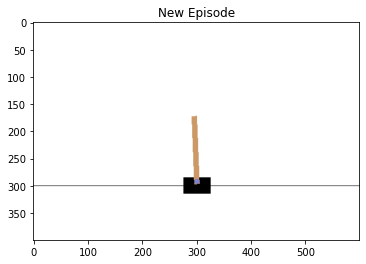

In [3]:
# Load the cart-pole environment
env = gym.make('CartPole-v1')


# Reinitialize the environment for an episode
observation = env.reset()

# Look at the features the agent will observe during training...
display(observation)

# Render the scene for our visualization purposes...
plt.imshow(env.render(mode='rgb_array'))
plt.title("New Episode") 
plt.show()

The black box at the bottom represents a cart which can be pushed to the left or right along the black line without friction. There is a pole balanced at the center of the cart which will begin to fall either to the left or right depending on the small amount of displacement of the pole's angle from 90 degrees. The agent will be allowed to apply a small force in either the left or right direction in an attempt to compensate for the falling pole in an attempt to balance it on the cart. For every timestep where the agent can keep the pole within 12 degrees of fully upright, the agent will be rewarded (r=1). We will also manually punish the agent by a larger amount (r=-10) when it "drops the pole" to more explicitly discourage poor performance (instead of only encouraging good performance). However, the agent will initially start untrained and will not be very good at understanding how to use the available actions to make sure that it experiences many rewards and avoids punishment. Also, the agent is provided with a list of features which correspond to the configuration of the environment for making such decisions:

| Index | Feature | Minimum | Maximum |
| --- | --- | --- | --- |
| 0 | Cart Position | -2.4 | 2.4 |
| 1 | Cart Velocity | -$\infty$ | $\infty$ |
| 2 | Pole Angle | -41.8 | 41.8 |
| 3 | Pole Velocity | -$\infty$ | $\infty$ |

Older approaches to solving this problem have leveraged various methods to reencoding the input features into more informative forms, such as fuzzy bucket or thermometer encodings. However, more recent neural networks have been shown to be successful without having to reencode our input features which is both more intuitive and practical. Here we will provide this 4-element vector of features to represent the *state* of the environment for our network.

Now that we have seen how to observe the environment, let's see if we can perform some actions (in this case completely random) to see if we can interact with the environment over time...

In [4]:
# Shape of the observation vectors
display(env.observation_space.shape)

# Number of possible actions
display(env.action_space.n)

(4,)

2

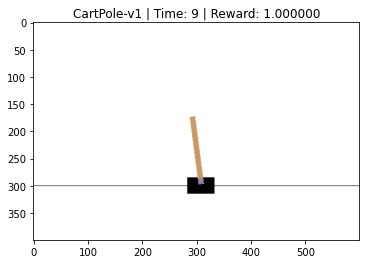

In [14]:
# Initialize the environment and perform 10 random actions
env.reset()
reward = 0.0
for time in range(10):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    observation, reward, done, info = env.step(np.random.choice(env.action_space.n)) # take a random action
    if (done):
        break
clear_output(wait=True)

Let's unpack this a little...

First, we `reset()` the environment object to set up the initial conditions of the episode. This is basically with the pole *very nearly* straight. We then loop over 10 iterations of interaction with the environment (one iteration is a *time step*). One each time step we will first, `render()` the current state and plot the corresponding image. In order to to this progressively (i.e. so there are not 10 different images displayed as output for the cell) we will then call `clear_output()` which was imported from `IPython.display`. This resets the output buffer even if a prior image was sent to the browser, hence we use the `wait=True` option to ensure rendering was over before clearing it away. Then we display the current plot (note that `plt.show()` is not being used) using the `display(plt.gcf())` command. In this way, on each time step the resulting plot will be rendered on top of the last plot, resulting in a "movie" of the output.

On each time step, we utilize the `step()` function to both indicate which action we would like to perform (`np.random.choice(env.action_space.n))`) and then collect the new state that results from taking this action (`observation`) along with additional data (r=`reward`, `done`, and `info`). We will not use the `info` field for working with this environment, but other environments may report additional information besides the other three (which are returned by default). The `reward` is the scalar reward value obtained from visiting the new state, and the `done` flag indicates whether the cart has moved beyond the boundaries of the task or beyond the 12 degree range allowed. It will be `False` until one of these two termination conditions is met when it will then be returned as `True`.

The size of the action space for the problem is 2 since there are only two actions: apply force to the left or apply force to the right. We are just sampling randomly from these two actions on each step, so there is no intelligence in this agent. However, it should now be clear how the agent can be programmed to interface with the environment. All of our learning will consist in deciphering which action would need to be performed given the current state of the environment.

We will come back to visualization of the task in this way later on when testing our agent's performance, but for now we will simple use the 4-element observation vector, 2 available actions, and scalar reward signal to train up a Q-learning agent to solve the problem.

Our first step along this path is to create a neural network model which tried to predict the Q-value associate with state-action pairs, $Q(s,a)$. The network will receive the obsevation vector ($s$) as input, and then produce a $Q(s,a)$ for *each action*. Therefore, we will build a network with 4 input units and 2 output units. Q-values are also real-valued, so we will utilize the `linear` activation function for the output layer, similar to regression problems. Let's set up the network now, and see how we might use it to select an action for our agent to perform...

In [6]:
import tensorflow.keras as keras
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
import numpy as np

# A simple multilayer architecture....
def make_model(state_size,action_size):
    model = keras.Sequential()
    model.add(keras.layers.Dense(20, input_shape=[state_size], activation='relu'))
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(action_size, activation='linear'))
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.001))
    return model

model = make_model(env.observation_space.shape[0],env.action_space.n)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 562
Trainable params: 562
Non-trainable params: 0
_________________________________________________________________


The network will be used to calculate/store the Q-function. Since we prefer to select actions that have high value (highest Q), we will present an state vector (`observation`) to the network and utilize the network outputs as predictions of the corresonding Q-values for the two state-action pairs that we are considering at the current time step. While we completed 10 time steps above randomly selecting our actions, instead the network will provide us with Q-values for making the decision.

In [7]:
# Turn our observation vector into a matrix of observations
# with only -one- observation and run predict()
Q = model.predict(np.expand_dims(observation,axis=0))
Q

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


array([[-0.03118069, -0.02980229]], dtype=float32)

These are the predicted Q-values for the "left" and "right" actions for this environment. While the agent is using a randomly initialized network, and so will generally not produce reasonable Q values just yet, we will see this converge to the *sum of discounted rewards* desired under Q-learning theory. We will cover that more later, but for now let's see how we use that information to make a decision about how to act.

The general idea is to prefer actions with the larger Q values, so generally we will select the action (either 0 for left of 1 for right) with the higher value:

In [8]:
np.argmax(Q)

1

Clearly, the action with the higher Q-value is easily selected using the `argmax()` function. This is the idea behind **exploitation** in reinforcement learning: we utilize our learned knowleged of Q-values to make decisions on actions to perform. However, it doesn't explain how we should encourage **exploration** where we sometimes *do not* follow our Q-function. A common strategy is to employ an $\epsilon$-soft action selection policy. In this kind of policy, we will select our action using `argmax()` above, **except** for some fraction of the time steps, $\epsilon$, when we instead choose a *random action* just like our initial exploration with such actions earlier. We usually keep $\epsilon$ small so that these are *rare* events, but we can also treat it like any other hyperparameter and *anneal* it over time. In this case $\epsilon$ starts high (1) and is then decayed to a small value over time (usually no lower than a small fraction, for example 0.01).

In [9]:
# Example e-soft policy...
epsilon = 0.5 # Half of the time, a random action is chosen...
action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
action

0

Let's hook the agent into the environment, and see what happens...

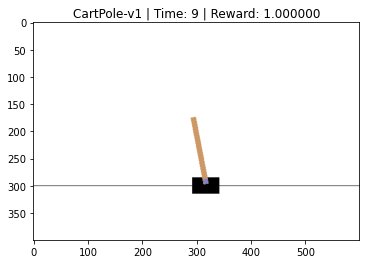

In [10]:
# Initialize the environment and let the agent decide!
observation = env.reset()
epsilon = 0.0 # No exploration!
reward = 0.0
for time in range(30):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    Q = model.predict(np.expand_dims(observation,axis=0)) # Compute Q
    action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
    observation, reward, done, info = env.step(action) # take action!
    if (done):
        break
clear_output(wait=True)

OK, so the agent can easily be used to control the cart, but it currently can't do a very good job since we have not learned the correct Q-values for this environment. We will need to program up the learning part next. There are a few moving parts here that we need to put into place:

1. Replay memory storage
2. Target Q-function model
3. Replay learning function

First, let's talk a little about *replay memory*. While we could perform Q-learning on each time step and make the network learn *on-line* while perform the task, this leads to problems with training neural networks which require folding in many training examples from a variety of state-action pairs in order to converge to the correct Q-function. The reason for this is because there is so much information shared between successive time steps on many reinforcement learning tasks. That is, the new state will "*look*" very similar to the last state we just came from since the actions don't cause drastic changes in observations. Even if drastic changes *were* made, the sequence of states that are experience are *temporally* similar (as in, they occur at similar points in time) so that the network is more focused on the most temporally and spatially similar observations while learning. This will lead the network to become focused more on the present learning scenarios and forget (or more correctly, overwrite) learned Q-values from past or even future observations that it has (or will) encounter. Therefore, we will retain a memory of the last, say 10000, state transitions and then draw a random sample from this memory bank for training. In this way, we will be drawing observations which are neither spatially nor temporally similar (on average) and the network will then be able to leverage learning from a wide range of experiences instead of the most current only.

In actuality, we will let the network complete an episode, and then run through several batches of observations from the replay memory to train the Q-function. We will then return to complete another episode, followed by another round of replay training. This *replay memory* is **critical** to the success of a good reinforcement learning agent so allocating a significant amount of storage space and heavily leveraging many random samples from it is the **key** technique to designing a successful reinforcement learning agent using a neural network. Research is on-going on ways to mitigate the size and training epochs of such a memory for more practical use in memory-intensive applications.

Second, we will utilize the *target function* network strategy. While we are running replay memory training, we will be changing Q values (updating the function). However, the very network that is generating our Q-values for the current time step is also generating our Q-values for the next time step (and so on). We also utilize the *difference* between these subsequent Q-values to update the network (to set our target Q-values). This means when we update a Q-value (and share weights with other Q-values) we inadvertently update other Q-values as well. There is a *moving target* problem here where the network is trying to speed up with or slow down with it's own Q-value updates! This can destabilize the learning capabilities of a neural network similar to how the gradients explode or disapper in a recurrent neural network (since you are reusing the same weights to calculate the predictions and targets, it forms a feedback loop). We can eliminate this instability (to a large degree) by making a copy of our current network Q-network, and only using this copy to generate targets. This means that the *target network* isn't trained, but only used to create the targets for the main model. These targets will therefore be fixed until we are finished training our main Q-function model. Then, we can just occasionally copy over the weights from our trained network into the target network again before the next round of training. While not as critical as the replay memory above, using a *target model* makes for a *drastically easier training experience* by largely eliminating the moving target problem.

Finally, we just need to stitch together the *replay memory* and *target model* to form the replay memory training function which will train the model to learn from the replay memory for a specified number of randomly sampled batches, and then update the target function at the end...

In [11]:
# Step 1 - Replay Memory Class
class ReplayMemory:
    def __init__(self, memory_size, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.size = 0
        self.maxsize = memory_size
        self.current_index = 0
        self.current_state = np.zeros([memory_size,env.observation_space.shape[0]])
        self.action = [0]*memory_size # Remember, actions are integers...
        self.reward = np.zeros([memory_size])
        self.next_state = np.zeros([memory_size,env.observation_space.shape[0]])
        self.done = [False]*memory_size # Boolean (terminal transition?)

    def remember(self, current_state, action, reward, next_state, done):
        # Stores a single memory item
        self.current_state[self.current_index,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False)
            
            # Slice memory into training sample
            current_state = self.current_state[current_sample,:]
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state = self.next_state[current_sample,:]
            done = [self.done[j] for j in current_sample]
            
            # Obtain model's current Q-values
            model_targets = model.predict(current_state)
            
            # Create targets from argmax(Q(s+1,a+1))
            # Use the target model!
            targets = reward + gamma*np.amax(target_model.predict(next_state),axis=1)
            # Absorb the reward on terminal state-action transitions
            targets[done] = reward[done]
            # Update just the relevant parts of the model_target vector...
            model_targets[range(sample_size),action] = targets
            
            # Update the weights accordingly
            model.fit(current_state,model_targets,
                     epochs=1,verbose=0,batch_size=sample_size)
            
        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

Here, I create a class and relevant member functions for performing the key functions of the memory model: remembering and replay training. The `remember()` function simply takes the components of a single time step from the environment and stores it in a set of pre-allocated numpy arrays and lists. Once the end of the storage space has been reached, the memory will simply reset the index back to the beginning of these data structures. This means the memory stores the most recent experiences of the agent, but over *many* episodes.

The `replay()` function will then create random slides of these data structures in order to form the training patterns for our Q-function network. The sample size of the iterations as well as the number of iterations used in this training regime is important. Too few iterations or too small of a sample size can make the training take significantly longer in terms of the number of episodes. However, increasing these values can also lead to longer training time in-between episodes, but this is usually worth the trade-off.

Finally, we see in the `replay()` function the calculation of the target values for the Q-function. Essentially, we are trying to calculate $Q(s,a) = r(s+1) + \gamma Q(s+1,a+1)$. This means that the Q-value of only one action, and therefore only one output unit, will be updated for each experience. We have to first calculate the Q-values for all actions (since these are the natural outputs of the network) and then use this vector as the targets *except* we change the value of the one output unit we need to update. Also, if the action resulted in visiting a terminating state, then we simply let $Q(s,a) = r(s+1)$ instead since the next state will have no action to consider (and therefore no correspnding $Q(s+1,a+1)$). These mappings are a little complex, so think carefully through the slicing operations being performed in this function. For any targets that were not changed, the network will have no error for those units. However, the single modified target unit will produce changes in the network weights.

We are now ready to begin training our model using our data structures. Let's begin by setting up the relevant hyperparameters for our approach...

In [12]:
# Full setup for the task...

# For keeping track of performance
from collections import deque

# Hyperparameters
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.01
episodes = 1000

replay_iterations = 100
replay_sample_size = 256

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)

# Initialize the environment and agent data structures
env = gym.make('CartPole-v1')
model = make_model(env.observation_space.shape[0],env.action_space.n)
target_model = make_model(env.observation_space.shape[0],env.action_space.n)
memory = ReplayMemory(10000,env.observation_space.shape[0],env.action_space.n)

We set several parameters for the training here which are also critical for good performance. The `gamma` ($\gamma$) parameter controls the discount in the future reward values and should be set in the range $[0,1)$. Normally, this is kept fairly close to one so that there is some preference for actions which lead quickly to similar reward patterns, but without losing a strong preference for actions which lead to more total reward in general. The `epsilon` ($\epsilon$) parameter controls the amount of exploration attempted. This is typically started very high (100% in this example) and is decreased at each episode by to a fraction (`epsilon_decay`) before it plateaus to the `epsilon_min` value (1%). This kind of annealing schedule may need to be adjusted carefully for different problems. Finally, we set the number of replay samples to generate to 100 and the size of the samples to 256 memories per iteration. The learning rate of the network and network architecture can also play an important role, but these were set in the `make_model()` function that we made above.

Now we are ready to begin training...

In [13]:
# Perform the training!
for episode in range(episodes):
    current_state = env.reset()
    for time in range(500):
        Q = model.predict(np.expand_dims(current_state,axis=0)) # Compute Q
        action = np.random.choice(env.action_space.n) if np.random.random() < epsilon else np.argmax(Q)
        next_state, reward, done, info = env.step(action) # take action!
        if done:
            reward = -10.0
        memory.remember(current_state,action,reward,next_state,done) # Store in memory...
        current_state = next_state # Transition to next state!
        if (done):
            break
    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
    times_window.append(time)
    mean_time = np.mean(times_window)
    mean_times.append(mean_time)
    print('\rEpisode %d/%d - time: %d, mean-time: %d, epsilon: %f'%(episode+1,episodes,time,mean_time,epsilon),end='')
    
    # Training...
    memory.replay(model,target_model,replay_iterations,replay_sample_size,gamma)
print()

Episode 1000/1000 - time: 188, mean-time: 266, epsilon: 0.010000


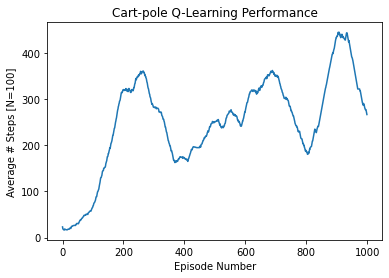

In [15]:
# Plot results
plt.plot(mean_times)
plt.title("Cart-pole Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Average # Steps [N=100]")
plt.show()

The code above will of course vary in performance. Here are a couple of more plots of the performance after initializing the neural network afresh and training for 1000 episodes...

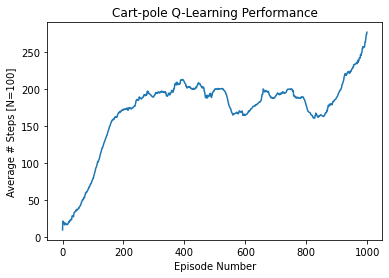

In [13]:
# Plot results
plt.plot(mean_times)
plt.title("Cart-pole Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Average # Steps [N=100]")
plt.show()

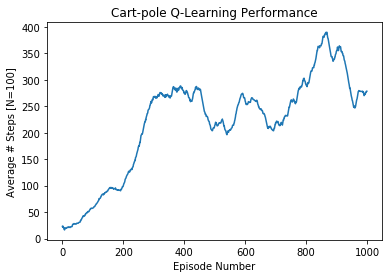

In [209]:
# Plot results
plt.plot(mean_times)
plt.title("Cart-pole Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Average # Steps [N=100]")
plt.show()

We used a `deque` above to store the number of time steps that the agent kept the pole and cart within the proper parameters of the task for the last 100 episodes. We calculated the mean number of time steps after each episode using this sliding window approach to track the learning performance of the network. This is quite a bit different from other learning problems where it is relatively simple to calculate an accuracy or error statistic from testing data. Here, we don't know what the final Q-function values need to be, and instead have to rely on performance statistics to assess the network.

The graph shows the increasingly better performance of the network over episodes. However, we can also see that there are periods of increase and decrease in performance: it is not a clearly improving at all times. The accepted definition of "success" for this task is taken to be 195 average time steps for at least 100 episodes. We can clearly see this being the case starting at around episode 300, where the average performance crosses 200 time steps. This perormance persists for the remaining 700 episodes (never dropping below 200). Given enough training time, we might expect the agent to perform the task for nearly 400 time steps on average given that that performance was observed for a short time during the above training experience.

Finally, we can see how the agent performs at the task via observation...

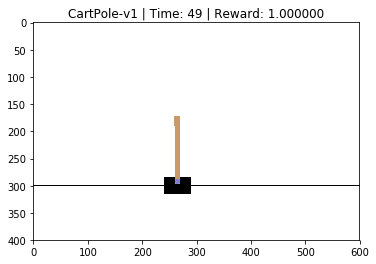

In [210]:
# Test out the agent!
# Initialize the environment and let the agent decide how to act!
observation = env.reset()
for time in range(50):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    display(plt.gcf())
    Q = model.predict(np.expand_dims(observation,axis=0)) # Compute Q
    action = np.argmax(Q)
    observation, reward, done, info = env.step(action) # take action!
    if (done):
        break
clear_output(wait=True)

Observing this task is fairly tedious since the frames render rather slowly in the notebook environment. Nevertheless, the agent can clearly balance the pole on the cart after completing the above training regime.

In essence, we have trained up a neural network to implement the Q-function for this task, and these Q-values are used to implement a good policy to solve the cart-pole problem.

In [14]:
# Stop the Xvfb (used for rendering above)
vdisplay.stop()